# Run cells from AllenDB

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

#after the above cell has restarted the session, run all below

In [1]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [2]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

#define constants

In [3]:
# Mouse L2/3 SST (Som) cell
# http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112
specimen_id = 476686112
model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

Download the cell

In [4]:
!pip install --quiet allensdk neuron

In [5]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

In [6]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 477878284



[{'id': 477878284,
  'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 476686112},
 {'id': 497232660,
  'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 476686112}]

In [7]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-05-02 01:40:09,223 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-05-02 01:40:09,531 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-05-02 01:40:09,666 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-05-02 01:40:09,826 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

In [8]:
# Compile the modfiles
!nrnivmodl modfiles > /dev/null 2>&1

## Build the cell

**NOTE:** Control the soma area in the `build_cell` function below.

In [9]:
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    #suppress output
    devnull = open(os.devnull, 'w')
    old_stdout, old_stderr = sys.stdout, sys.stderr
    sys.stdout = devnull
    sys.stderr = devnull
    ##

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    # Restore stdout/stderr
    sys.stdout, sys.stderr = old_stdout, old_stderr
    devnull.close()
    ##

    return h

def set_simulation(hoc_object,sim_params, soma_diam_multiplier = 1.0):
    from neuron import h
    h.load_file("stdrun.hoc")
    stim = h.IClamp(hoc_object.soma[0](0.5))
    stim.amp = sim_params['stim_amp']
    stim.delay = sim_params['stim_delay']
    stim.dur = sim_params['stim_dur']
    h.tstop = sim_params['h_tstop']
    h.dt = sim_params['h_dt']
    # h.steps_per_ms = 1 / h.dt
    return h, stim

#set simulation parameters

In [10]:
sim_params = {
                'stim_amp': -0.1,
                'stim_delay': 100,
                'stim_dur': 1000,
                'h_tstop': 1200,
                'h_dt': 0.025
                }


#Morphology

In [11]:
using_hoc = False
soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier,using_hoc)
# hobject = build_cell(soma_diam_multiplier)

In [12]:
print(f"Soma area: {hobject.soma[0](0.5).area()}")
print(f"Soma diam: {hobject.soma[0].diam}")
print(f"Soma L: {hobject.soma[0].L}")

Soma area: 503.6323076932052
Soma diam: 12.661399841308594
Soma L: 12.661407470703125


## Passive properties

In [13]:
# Soma area from the previous cell
computed_soma_area = hobject.soma[0](0.5).area() * 1e-8 #(cm2)
# User-provided desired properties
user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)
spps = ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)
print(spps)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)


programmatically change the json

In [14]:
import json

for item in os.listdir():
  if item.endswith('_fit.json'):
    config_filename = item
    print(config_filename)

with open(os.path.join(config_filename),'r') as file:
    data = json.load(file)

#save the original data
original_fit = {
                'cm':None,
                'g_pas':None,
                'cm': None,
                'e_pas':None
                }

for item in data['genome']:

  if item['name'] == 'g_pas':
    original_fit['g_pas'] = item['value']

  if item['name'] == 'cm':
    original_fit['cm'] = item['value']


for item in data['passive'][0]['cm']:
  original_fit['cm'] = item['cm']

original_fit['e_pas'] = data['passive'][0]['e_pas']

#set new parameters and choose new or old fit for the _fit.json file
new_fit = {
            'cm':spps.Cm,
            'g_pas':spps.g_bar_leak,
            'cm': spps.Cm,
            'e_pas':spps.e_rev_leak
            }


476686112_fit.json


choose the spp numbers or the original

In [23]:
###############################
chosen_fit = new_fit
#################################
for item in data['passive'][0]['cm']:
  item['cm'] = chosen_fit['cm']


data['passive'][0]['e_pas'] = chosen_fit['e_pas']

for item in data['genome']:

  if item['name'] == 'g_pas':
    item['value'] = chosen_fit['g_pas']

  if item['name'] == 'cm':
    item['value'] = chosen_fit['cm']

with open(config_filename, 'w') as file:
    json.dump(data, file, indent=4)

#run the simulation

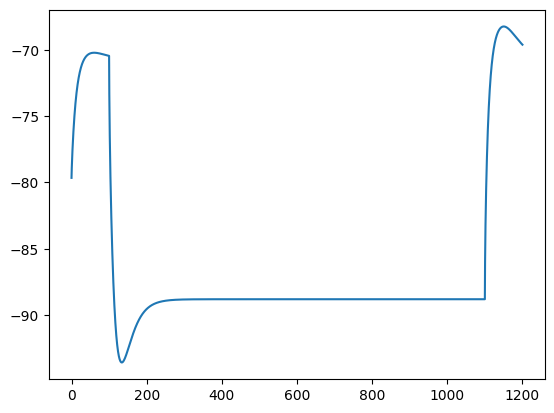

In [24]:
# sim_params['stim_amp'] = 0.1

using_hoc = False
soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier,using_hoc)#rebuild the cell to make sure the set_simulation() is using the correct hobj


h, stim = set_simulation(hobject,sim_params)
v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.finitialize()
h.run()
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(T,V)
plt.show()

In [25]:
print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, sim_params['stim_delay'], h.tstop, sim_params['stim_amp']))
print(f"V-rest: {v.as_numpy()[300]}")

GettablePassiveProperties(R_in=231.33298179751492, tau1=8.35, tau2=971.4250000000001, sag_ratio=1.0366001579094744, V_rest=-70.45206401772245)
V-rest: -75.08537713836441


## FI-Curve

In [26]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [27]:
frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

start_idx = int(sim_params['stim_delay']/sim_params['h_dt'])
end_idx = int(sim_params['stim_dur']/sim_params['h_dt'])

for amp in amps:
    h, stim = set_simulation(hobject,sim_params)
    v = h.Vector().record(h.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx]))

In [28]:
spikes = count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx])
if spikes:
  freq = spikes/(len(spikes)/1000)
  print(f"Frequency: {freq}")
else:
  print("No spikes")

No spikes


In [29]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 0
0.1: 0
0.15: 0
0.2: 0
0.25: 0
0.3: 0


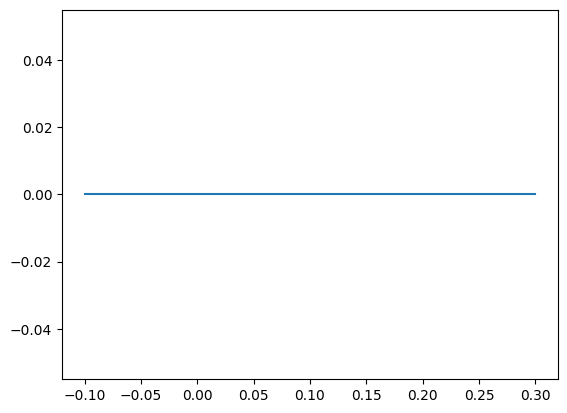

In [30]:
# Change NaP to shift rheobase
# Change SK to change slope
plt.plot(amps, frequenies)